100%|███████████████████████████████████████| 1129/1129 [00:30<00:00, 37.12it/s]


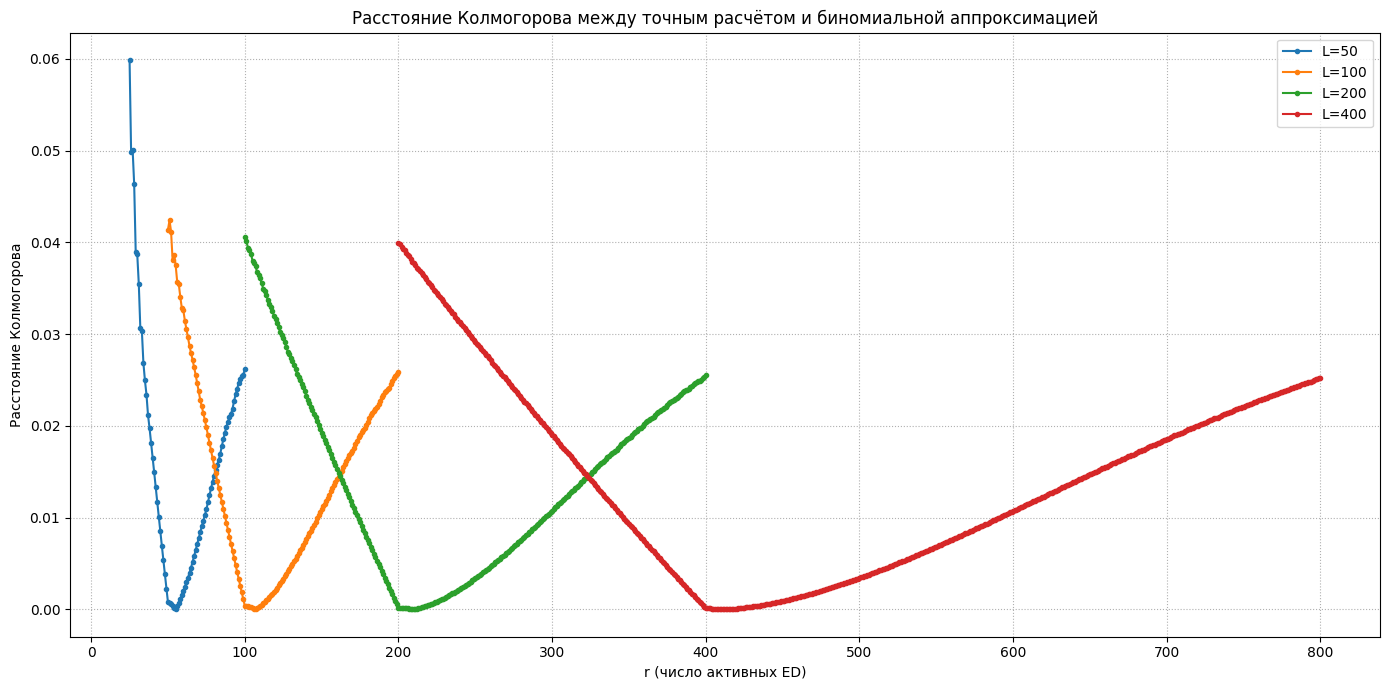

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import comb
from decimal import Decimal, getcontext
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import multiprocessing

# Установка точности
getcontext().prec = 100

def beta_k_exact_decimal_safe(r, k, L):
    if k < 0 or k > min(L, r):
        return Decimal(0)

    sum_result = Decimal(0)
    upper_limit = min(L - k, r - k)
    factorial_cache = [Decimal(1)]
    power_cache = {}

    for i in range(1, int(r) + 1):
        factorial_cache.append(factorial_cache[-1] * Decimal(i))

    for i in range(int(upper_limit) + 1):
        sign = Decimal((-1)**i)
        binom = Decimal(comb(int(L - k), int(i)))
        factorial_part = factorial_cache[int(r)] / factorial_cache[int(r - k - i)]

        base = int(L - k - i)
        exponent = int(r - k - i)

        if base <= 0 and exponent <= 0:
            continue
        if (base, exponent) not in power_cache:
            power_cache[(base, exponent)] = Decimal(base) ** exponent

        term = sign * binom * factorial_part * power_cache[(base, exponent)]
        sum_result += term

    pre_factor = Decimal(comb(int(L), int(k))) / (Decimal(L) ** int(r))
    beta = pre_factor * sum_result

    return max(float(beta), 0.0)

def beta_k_approx(r, k, L):
    m = min(L, r)
    p = (r * ((L - 1) / L)**(r - 1)) / m
    return comb(m, k) * (p**k) * ((1 - p)**(m - k))

def kolmogorov_distance(dist1, dist2):
    return np.max(np.abs(np.cumsum(dist1) - np.cumsum(dist2)))

def calculate_distance(args):
    L, r = args
    k_values = np.arange(0, min(L, r) + 1)

    exact_probs = np.array([beta_k_exact_decimal_safe(r, k, L) for k in k_values])
    approx_probs = np.array([beta_k_approx(r, k, L) for k in k_values])

    exact_sum = exact_probs.sum()
    approx_sum = approx_probs.sum()
    if exact_sum > 0:
        exact_probs /= exact_sum
    if approx_sum > 0:
        approx_probs /= approx_sum

    dist = kolmogorov_distance(exact_probs, approx_probs)
    return {'L': L, 'r': r, 'Kolmogorov_distance': dist}

if __name__ == "__main__":
    multiprocessing.set_start_method("fork")  # только для Unix (macOS/Linux)

    L_values = [50, 100, 200, 400]
    step_factor = 1
    args_list = [(L, r) for L in L_values for r in range(L // 2, 2 * L + 1, step_factor)]

    results = []
    with ProcessPoolExecutor() as executor:
        for result in tqdm(executor.map(calculate_distance, args_list), total=len(args_list)):
            results.append(result)

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(14, 7))
    for L in L_values:
        subset = results_df[results_df['L'] == L]
        plt.plot(subset['r'], subset['Kolmogorov_distance'], marker='.', label=f'L={L}')

    plt.xlabel('r (число активных ED)')
    plt.ylabel('Расстояние Колмогорова')
    plt.title('Расстояние Колмогорова между точным расчётом и биномиальной аппроксимацией')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.savefig('kolmogorov_distance_plot.png', dpi=300)
    plt.show()
